## Sneak Peak: Frank Lab place field analysis using NWB 2.0 + Query Framework (beta)
This is an sneak peak of an approach for querying and analyzing NWB 2.0 files in the Frank Lab. We would like to build a Query Framework for efficiently working with data stored in NWB files, including eventually querying across days, animals, and even experiments. As a first step toward this goal,
we show some canonical Frank Lab queries and analyses using a single day of an animal from one experiment. 

In addition to vanilla NWB, we use Frank Lab NWB extensions for representing behavioral tasks and apparatuses. See 'create_franklab_nwbfile.ipynb' for a walk-through of how we create these NWB files, and 'franklab.extensions.yaml' for the specification itself. 

We have also developed some helper classes for querying data, found in the 'nwb_query.py' module. These classes include, for example, facilities for handling time interval queries into continuous data (e.g. animal position) or discrete "point" data (e.g. spike times). Importantly, we keep track of the valid intervals (i.e. observation intervals) over which all data are valid. We make sure that the results of any query include the appropriate new valid intervals, so you can just query for particular time intervals, and not have to keep track of the intervals logic.  These classes are still protoypes. Some of the features might eventually be incorporated into NWB itself, while other aspects could become part of the future Query Framework.


In [1]:
%load_ext autoreload
%autoreload 2

# General
import pynwb
import numpy as np
import pandas as pd
import networkx as nx

# Local
from nwb_query import TimeIntervals as TI
from nwb_query import ContinuousData, PointData, EventData, TimeIntervals, plot_PointData_multiple, plot_ContinuousData, plot_EventData, point_to_line_dist
import fl_extension_helpers as flh


# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.solid_capstyle': 'butt'})
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

### Data import and analysis parameters
We will analyze data for one day of data for one animal, focusing particularly on a single epoch of behavioral data and a single clustered unit for spiking data.

In [2]:
# what data to analyze
d = {}
d['anim'] = 'bon'
d['day'] = 4 # 1-indexed
d['epoch'] = 4 # 1-indexed
d['cluster_id'] = 30

# analysis configuration
c = {}
c['speed_threshold'] = 0.05 # m/s

### Read NWB file
For a walk-through of how to create an NWB file from data in the Frank Lab's old Matlab "Filter Framework" format, see the notebook 'create_franklab_nwbfile.ipynb'.

In [3]:
animday = '{}{:02d}'.format(d['anim'], d['day'])
nwb_filename = './' + animday + '.nwb'

print('Loading file: %s' % nwb_filename)
io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()
 
sst = nwbf.session_start_time.timestamp()

Loading file: ./bon04.nwb


### Take a look at the NWBFile
This is a top-level of view of all of the types of data that are in the NWBFile. 

Some important things to note:
- LFP data are in <i>acquisition['LFP']</i>
- tetrodes metadata are in <i>electrode_grups</i>
- individual channels metadata are in <i>electrodes</i>
- metadata about individual epochs are in <i>epochs</i>
- behavioral data and metadata are in <i>modules['Behavior']</i>
- clustered units and spiking data are in <i>units</i>

In [34]:
print(nwbf)


root <class 'pynwb.file.NWBFile'>
Fields:
  acquisition: { LFP <class 'pynwb.ecephys.LFP'> }
  analysis: { }
  devices: { NSpike acquisition system <class 'pynwb.device.Device'> }
  electrode_groups: { 04-01 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-02 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-03 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-04 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-05 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-06 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-07 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-08 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-10 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-11 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-12 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-13 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-14 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-15 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-17 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-18 <class 'pynwb.ecephys.ElectrodeGroup'>,  04-19 <class 'pynwb.ecephys.ElectrodeGroup'>,

### Look at the Behavior data
The 'Behavior' module contains behavioral data (head direction, position, speed) and metadata (apparatuses and tasks). Looking more closely at the Speed data, we see that we have spearate TimeSeries objects for the speed in each epoch. 

These TimeSeries are all named 'Speed dX eY' for day X and epoch Y. A similar naming convention is used for Head Direction and Position data. For the time being, we will use these names to query for behavioral data from particular epochs. This is hacky. 

Our next development plan is to concatenate all of the epochs together into one long TimeSeries, using "valid intervals" to denote the time ranges over which the data are valid (i.e. the times between epochs are invalid, as no data could be there). The nice thing about this approach is we can query for particular epochs with a simple time query (just passing in the start/stop times of the epoch) without having to know anything about naming conventions.


In [42]:
print(nwbf.modules['Behavior'])
print('\nLooking more closely at "Speed"...\n')
print(nwbf.modules['Behavior']['Speed'])


Behavior <class 'pynwb.base.ProcessingModule'>
Fields:
  data_interfaces: { Head Direction <class 'pynwb.behavior.CompassDirection'>,  Position <class 'pynwb.behavior.Position'>,  Sleep <class 'fl_extension.Task'>,  Sleep Box <class 'fl_extension.Apparatus'>,  Speed <class 'pynwb.behavior.BehavioralTimeSeries'>,  W-Alternation <class 'fl_extension.Task'>,  W-track A <class 'fl_extension.Apparatus'>,  W-track B <class 'fl_extension.Apparatus'> }
  description: Behavioral data


Looking more closely at "Speed"...


Speed <class 'pynwb.behavior.BehavioralTimeSeries'>
Fields:
  time_series: { Speed d4 e1 <class 'pynwb.base.TimeSeries'>,  Speed d4 e2 <class 'pynwb.base.TimeSeries'>,  Speed d4 e3 <class 'pynwb.base.TimeSeries'>,  Speed d4 e4 <class 'pynwb.base.TimeSeries'>,  Speed d4 e5 <class 'pynwb.base.TimeSeries'>,  Speed d4 e6 <class 'pynwb.base.TimeSeries'>,  Speed d4 e7 <class 'pynwb.base.TimeSeries'> }



### Dataset Query: speed of a given animal, day, and epoch
#### NWBFile (one animal, day), epoch --> ContinuousData (speed)

Query for the speed of an animal during a single epoch. As mentioned above, we query based on the name of the epoch's Speed record. In the future we want to query directly on the time interval of the epoch.

We return an instance of ContinuousData, which is our class for data like animal speed and position that are, in principle, continuous functions that have a value at all time points. In other words, the animal has a speed at all times up to infinitesimal timesteps, but we only sample the animal's speed at some rate (e.g. our video framerate). 

We distinguish between continuous data (e.g. speed, position, head direction) from discrete point data (e.g. spiking, nose pokes) even though these are both "time series" data, because our interpretation of the underlying data are fundamentally different. For continuous data, samples represent a coarse model of the underlying continuous function, so it makes sense to, for example, interpolate between samples. In contrast, for discrete point data, samples are better though of as events generated by some underlying "point process", or as a series of delta functions.

In [6]:
speed_module_name = 'Speed d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
speed_h5py = nwbf.modules['Behavior']['Speed'][speed_module_name]
samples = pd.DataFrame(data=speed_h5py.data[()], columns=['speed'])
speed = ContinuousData(samples=samples, sample_times=speed_h5py.timestamps[()])
speed.valid_intervals  # the time over which we were measuring speed (this epoch)

TimeIntervals([1136409364.0273,1136410300.9887])

### Dataset Query: position of a given animal, day, and epoch
#### NWBFile (one animal, day), epoch --> ContinuousData (position)
Similar to above, now we query for the animal's position during a particular epoch by using the name of it's TimeSeries in the 'Behavior' ProcessingModule.

As with speed, animal position can be thought of as a continuous function of time, so we return a ContinuousData object.

*** All position records for epoch ***
# of measurements = 28082
# of intervals = 1
duration of intervals = 936.96 s


([<matplotlib.patches.Rectangle at 0x11b440470>],
 [[<matplotlib.lines.Line2D at 0x11b43f550>,
   <matplotlib.lines.Line2D at 0x11b49cfd0>]])

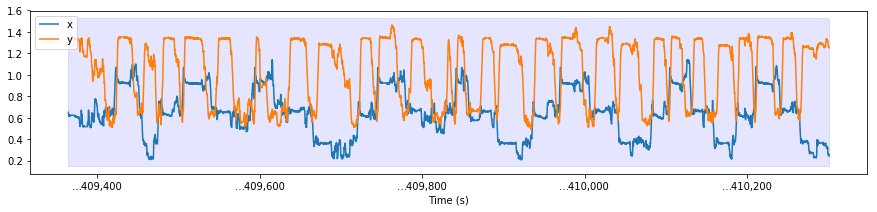

In [8]:
position_module_name = 'Position d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
position_h5py = nwbf.modules['Behavior']['Position'][position_module_name]
# position_data = np.array(position_h5py.data[()])
position_data = pd.DataFrame(data=position_h5py.data[()], columns=['x', 'y'])
position = ContinuousData(position_data, position_h5py.timestamps[()])

print('*** All position records for epoch ***')
print('# of measurements = %d' % position.samples.shape[0])
print('# of intervals = %d' % len(position.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(position.valid_intervals.durations()))

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
plot_ContinuousData(position)

### Dataset Query: spiking of a given animal and cluster
#### NWBFile (one animal), cluster --> PointData (spiking)
Now we will query for the spiking data of one clustered unit. These data live in 'units', which is a table with a row for each clustered unit. The spike times live in the column called 'spike_times'. We also grab the 'obs_intervals' column, which contain the intervals over which we were recording from the cell, and thus when it was even possible to see a spike. 

Observation intervals are essential for interpreting these data, because we can only compute metrics like rate with respect to the time over which it was possible for us to see a spike. As we start slicing time windows of a spiking record, it can quickly become messy to keep track of these observation intervals (often requiring intersections of many different intervals). Thus, we propose that all time-based data in the Query Framework will include observation intervals.

Unlike speed and position, unit spiking is not a continuous function, but instead can be thought of as a "point process" or a series of delta functions. We represent the unit spiking data as a PointData object, being sure to also provide the observation intervals.


In [9]:
spikes_t = nwbf.units['spike_times'][d['cluster_id']]
valid_intervals = TimeIntervals(nwbf.units['obs_intervals'][d['cluster_id']])
spiking_all = PointData(point_times=spikes_t, valid_intervals=valid_intervals)

print('*** Spiking for cluster %s ***' % d['cluster_id'])
print('# of spikes = %d' % spiking_all.point_times.shape[0])
print('# of intervals = %d' % len(spiking_all.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_all.valid_intervals.durations()))

*** Spiking for cluster 30 ***
# of spikes = 2192
# of intervals = 7
duration of intervals = 7163.00 s


### Time Query: Find spiking within all epochs where the rat did the W-alternation task
#### PointData (spiking), TimeIntervals (epochs) --> PointData (spiking)

The 'epochs' field of the NWBFile is a table with a row for each epoch. This table contains the start and stop times of each epoch, as well as the task that the animal was doing during that epoch. 

Here, we identify the epochs in which the animal was conducting a behavioral task called 'W-alternation'. We use these time intervals to query the spiking PointData, resulting in a new PointData object containing only the spiking data in W-alternation epochs. The valid intervals of this new PointData object are the intersection of the valid_intervals for all spiking data and the time intervals defining the W-alternation epochs. (see plot below)

*** Spiking for cluster 30 during W-Alternation behavioral epochs ***
# of spikes = 1855
# of intervals = 3
duration of intervals = 2812.25 s


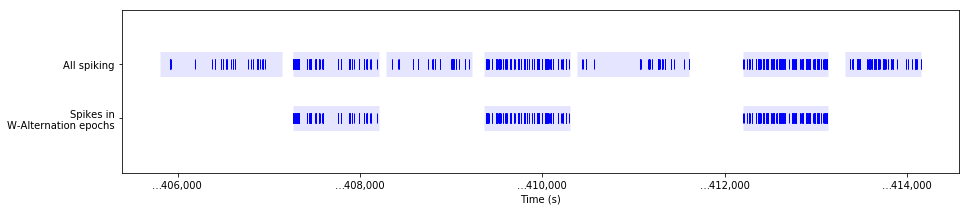

In [10]:
# Get start/stop times for all epochs where the rat ran the W Alternation task
epoch_types = np.array([task.name for task in nwbf.epochs['task'][:]])
behav_epoch_indices = np.where(epoch_types=='W-Alternation')[0]

# Build a TimeIntervals query with start/stop times of W Alternation behavioral epochs
behav_intervals = []
for i in behav_epoch_indices:
    epoch_start = nwbf.epochs['start_time'][i]
    epoch_stop = nwbf.epochs['stop_time'][i]
    behav_intervals.append([epoch_start, epoch_stop])
behav_intervals = TimeIntervals(np.array(behav_intervals)) # convert to TimeIntervals for query

# time_query on spiking during W Alternation behavioral epochs
spiking_behav = spiking_all.time_query(behav_intervals)

print('*** Spiking for cluster %s during W-Alternation behavioral epochs ***' % d['cluster_id'])
print('# of spikes = %d' % spiking_behav.point_times.shape[0])
print('# of intervals = %d' % len(spiking_behav.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_behav.valid_intervals.durations()))

# Plot spiking
spikeplots = [(spiking_all, 'All spiking'),
              (spiking_behav, 'Spikes in\nW-Alternation epochs')]

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)

pass # suppress output
    


### Time Query: Find spiking within a single behavioral epoch
#### PointData (spiking), TimeIntervals (epoch) --> PointData (spiking)

Now we want to query for spiking in a single epoch of interest. We get the start and stop times of this epoch from the 'epochs' table, and then we use this time interval to query the spiking PointData. This results in a new PointData with just the spiking and valid intervals from that epoch.

*** Spiking for cluster 30 during epoch 4 ***
# of spikes = 718
# of intervals = 1
duration of intervals = 936.96 s


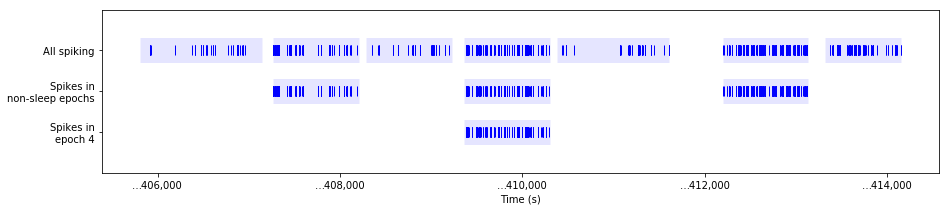

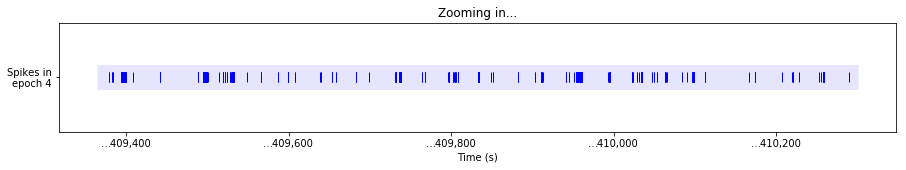

In [11]:
# Get epoch start/stop times from the NWB file
epoch_start = nwbf.epochs['start_time'][d['epoch']-1]
epoch_end = nwbf.epochs['stop_time'][d['epoch']-1]
epoch_interval = TimeIntervals(np.array([epoch_start, epoch_end]))

# time_query on spiking during the epoch
spiking = spiking_all.time_query(epoch_interval)

print('*** Spiking for cluster %s during epoch %d ***' % (d['cluster_id'], d['epoch']))
print('# of spikes = %d' % spiking.point_times.shape[0])
print('# of intervals = %d' % len(spiking.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking.valid_intervals.durations()))


# Plot spiking
spikeplots = [(spiking_all, 'All spiking'),
              (spiking_behav, 'Spikes in\nnon-sleep epochs'),
              (spiking, 'Spikes in\nepoch %s' % d['epoch'])]

fig1 = plt.figure(1, figsize=(15,3))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)

fig2 = plt.figure(2, figsize=(15,2))
ax2 = fig2.add_subplot(1, 1, 1)
plot_PointData_multiple([spikeplots[2]], axis=ax2)
ax2.set_title("Zooming in...")

pass # suppress output

### Analysis: Find time intervals where speed > threshold
#### ContinuousData (speed), lambda function --> EventData (time periods where animal speed > threshold)
Next, we want to find the time intervals within an epoch during which the animal was running faster than some speed threshold. 

Conceptually, we view this as an _analysis_, not a query like the time queries for epochs shown above. This is because we are not simply selecting a direct subset of a given data. Rather, we are asking for the set of time intervals when the speed data fulfills a function given boolean labmda function. The lambda function could have been something different, like "find the times of all upward threshold crossings, and then pad this by 5 seconds on either side." We only mention this to clarify our terminology when we speak of queries and analyses.

The resulting set of time intervals is neither a continuous functions (ContinuousData) or a discrete point processes (PointData). It is somewhat similar to a PointData, but instead of delta functions, we have a set of time intervals. As this is also a common form of data in an analysis workflow, we represent these with an EventData class. In the plot below, each vertical bar is actually a time interval where the animal was running, not a delta function like spiking.

*** Times where speed > threshold ***
# of events = 118
duration of events = 394.92 s
# of valid intervals = 1
duration of intervals = 936.96 s


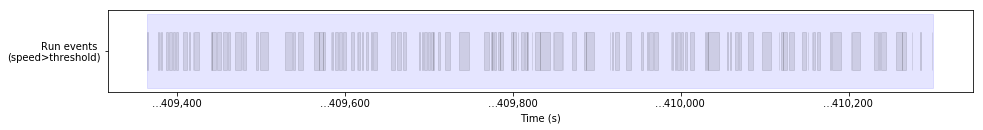

In [12]:
speed_threshold_fn = lambda x: x > c['speed_threshold']
speed_events = speed.filter_intervals(speed_threshold_fn)

print('*** Times where speed > threshold ***')
print('# of events = %d' % len(speed_events.event_intervals))
print('duration of events = %0.2f s' % np.sum(speed_events.durations()))
print('# of valid intervals = %d' % len(speed_events.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(speed_events.valid_durations()))

# TODO: Plot continuous speed
fig1 = plt.figure(1, figsize=(15.5,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_EventData(speed_events, axis=ax1)
ax1.set_yticks([1])
ax1.set_yticklabels(['Run events \n(speed>threshold)']) # eventually use metadata from PointData object
pass # suppress output

### Query: spiking during time intervals where speed > threshold
#### PointData (spiking), EventData (bouts where speed > threshold) --> PointData (spiking)
Now we want to query for spiking data during all of the time intervals where the animal was running above threshold (i.e. during all of the grey intervals in the plot above). To do this, we run a time query on the PointData object containing all spiking, passing in the EventData intervals from above. This results in a new PointData object whose valid intervals are the intersection of the running event intervals and the original spiking valid intervals. Here you can start to see how nice it is to have the valid intervals calculation handled for you behind the scenes. Some of these intervals contain spiking! (see plot below)

*** Spiking where speed > threshold ***
# of spikes = 373
# of intervals = 118
duration of intervals = 394.92 s



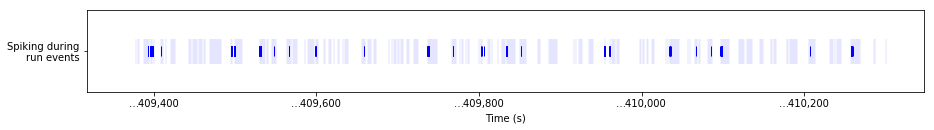

In [13]:
spiking_run = spiking.time_query(speed_events)  # Use the built-in time query method on PointProcess

print('*** Spiking where speed > threshold ***')
print('# of spikes = %d' % len(spiking_run.point_times))
print('# of intervals = %d' % len(spiking_run.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run.valid_intervals.durations()))
print()

print(spiking_run)

# Plot spiking
fig1 = plt.figure(1, figsize=(15,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple([(spiking_run, 'Spiking during\nrun events')], axis=ax1)

pass # suppress output

### Analysis: Mark each spike with the animal's current position
#### PointData (spiking), ContinuousData (position [m x 2]) --> PointData with marks (spike times with associated positions)

Now that we have spiking during run periods, we want to associate each of these spike times with the animal's position at the time of the spike. The process of associating each spike with associated position data can be thought of as "marking" (i.e. tagging) the spike times with the position data.

Recall that position is ContinuousData object (represetning a continuous function), whereas spiking is a PointData (representing a discrete point process). 

In [14]:
spiking_run_mark_pos = spiking_run.mark_with_ContinuousData(position)

print('*** Spiking where speed > threshold, marked with position ***')
print('# of marked spikes = %d' % len(spiking_run_mark_pos.point_times))
print('# of intervals = %d' % len(spiking_run_mark_pos.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run_mark_pos.valid_intervals.durations()))
print()

*** Spiking where speed > threshold, marked with position ***
# of marked spikes = 373
# of intervals = 118
duration of intervals = 394.92 s



### Query: Get animal locations during running events
#### ContinuousData (position [m x 2]), EventData (bouts where speed > threshold) --> ContinuousData (position [m_new x 2])

*** Position where speed > threshold ***
# of samples = 11954
# of intervals = 118
duration of intervals = 394.92 s

1136409364.0273


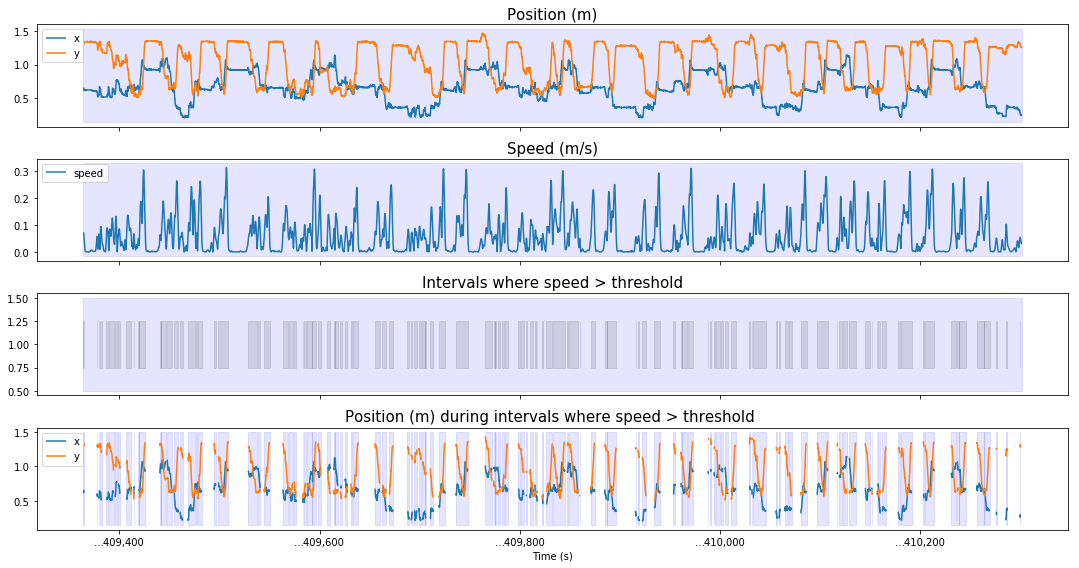

In [15]:
position_run = position.time_query(speed_events)

print('*** Position where speed > threshold ***')
print('# of samples = %d' % position_run.samples.shape[0])
print('# of intervals = %d' % len(position_run.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(position_run.valid_intervals.durations()))
print()

fig1 = plt.figure(1, figsize=(15,8))
ax1 = fig1.add_subplot(4, 1, 1)
ax1.set_title('Position (m)', fontsize=15)
plot_ContinuousData(position, axis=ax1)
ax1.label_outer()

ax2 = fig1.add_subplot(4, 1, 2, sharex=ax1)
ax2.set_title('Speed (m/s)', fontsize=15)
plot_ContinuousData(speed, axis=ax2)
ax2.set_xlabel('')
ax2.label_outer()

ax3 = fig1.add_subplot(4, 1, 3, sharex=ax1)
ax3.set_title('Intervals where speed > threshold', fontsize=15)
plot_EventData(speed_events, axis=ax3)
ax3.label_outer()

ax4 = fig1.add_subplot(4, 1, 4, sharex=ax1)
ax4.set_title('Position (m) during intervals where speed > threshold ', fontsize=15)
plot_ContinuousData(position_run, axis=ax4)

print(position.sample_times[0])
# ax1.set_xlim(1136409500, 1136409600)

plt.tight_layout()

pass

### Plot spikes by location

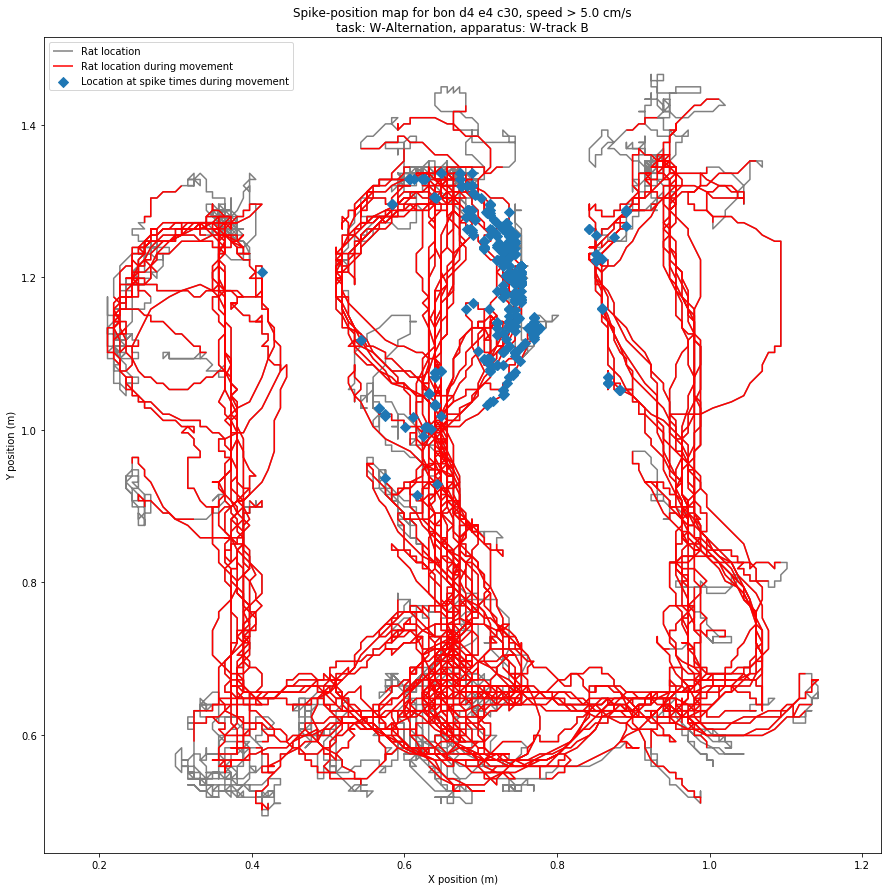

In [16]:
fig1 = plt.figure(1, figsize=(15,15))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.axis('equal')


task = nwbf.epochs['task'][d['epoch']-1]
appar = nwbf.epochs['apparatus'][d['epoch']-1]

# Line showing the animal's movement during the entire epoch
plt.plot(position.samples['x'], position.samples['y'], marker='', color='gray', label='Rat location', zorder=1)

# Lines showing animal movement during each interval where it was running
run_label = 'Rat location during movement'
for ivl in position_run.valid_intervals:
    ivl_data = position.time_query(TimeIntervals(ivl)).samples  # position at this valid interval 
    plt.plot(ivl_data['x'], ivl_data['y'], marker='', color='red', label=run_label, zorder=2)
    run_label = '_' # omit later lines from legend

# Markers for locations where unit spiked during animal running
plt.scatter(spiking_run_mark_pos.marks['x'], spiking_run_mark_pos.marks['y'], marker='D', s=50, label='Location at spike times during movement', zorder=3)

ax1.legend()
ax1.set_xlabel('X position (m)')
ax1.set_ylabel('Y position (m)')
ax1.set_title('Spike-position map for {} d{} e{} c{}, speed > {:0.1f} cm/s\ntask: {}, apparatus: {}'.format(
    d['anim'], d['day'], d['epoch'], d['cluster_id'], c['speed_threshold'] * 100, task.name, appar.name))

pass

### Dataset Query: task and apparatus
#### NWBFile (one animal, day), epoch --> franklab_apparatus.Task
#### NWBFile (one animal, day), epoch --> franklab_apparatus.Apparatus

In [17]:
# Query for task
task = nwbf.epochs['task'][d['epoch']-1]

# Query for apparatus
appar = nwbf.epochs['apparatus'][d['epoch']-1]

### Plot 2D position-normalized spiking
Also plot the linearized track geometry

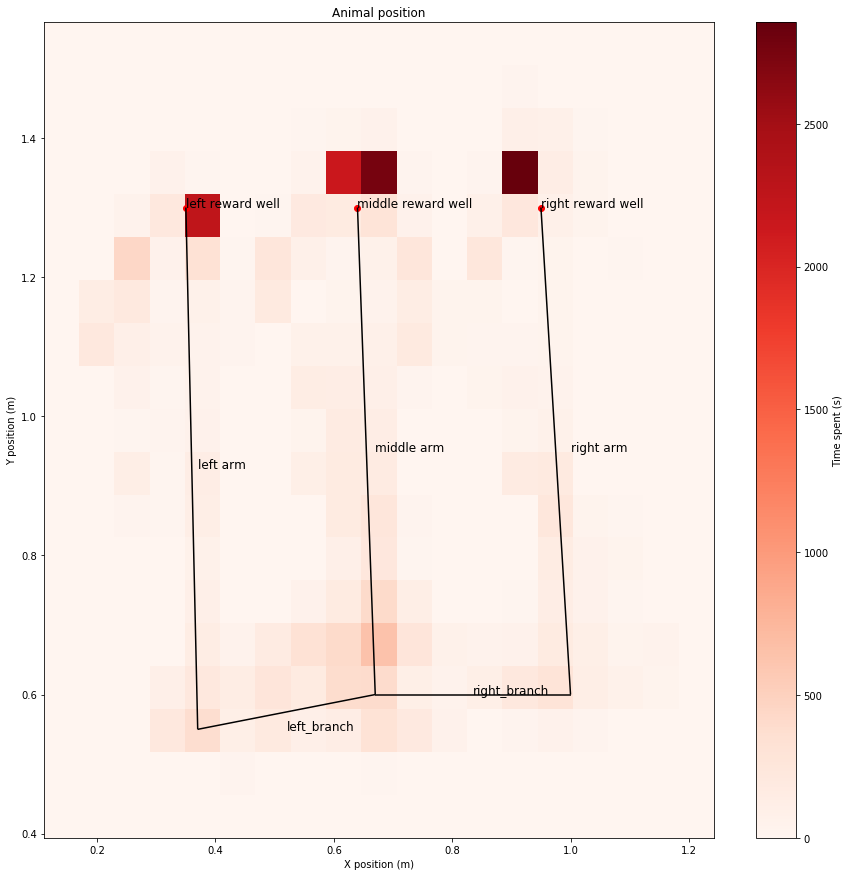

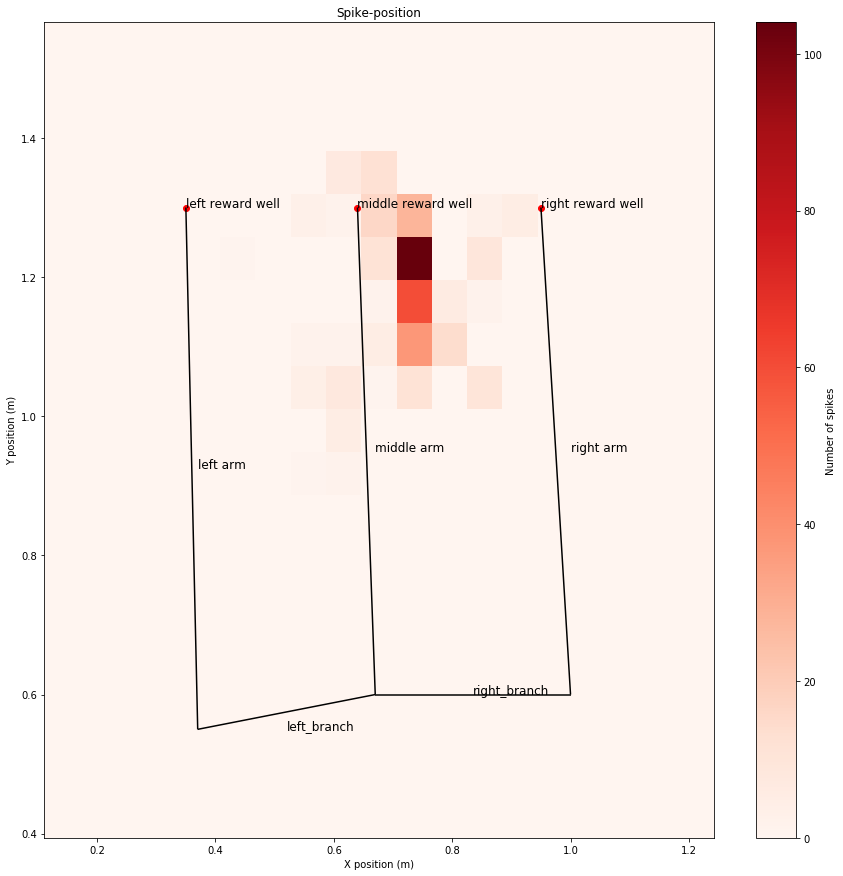

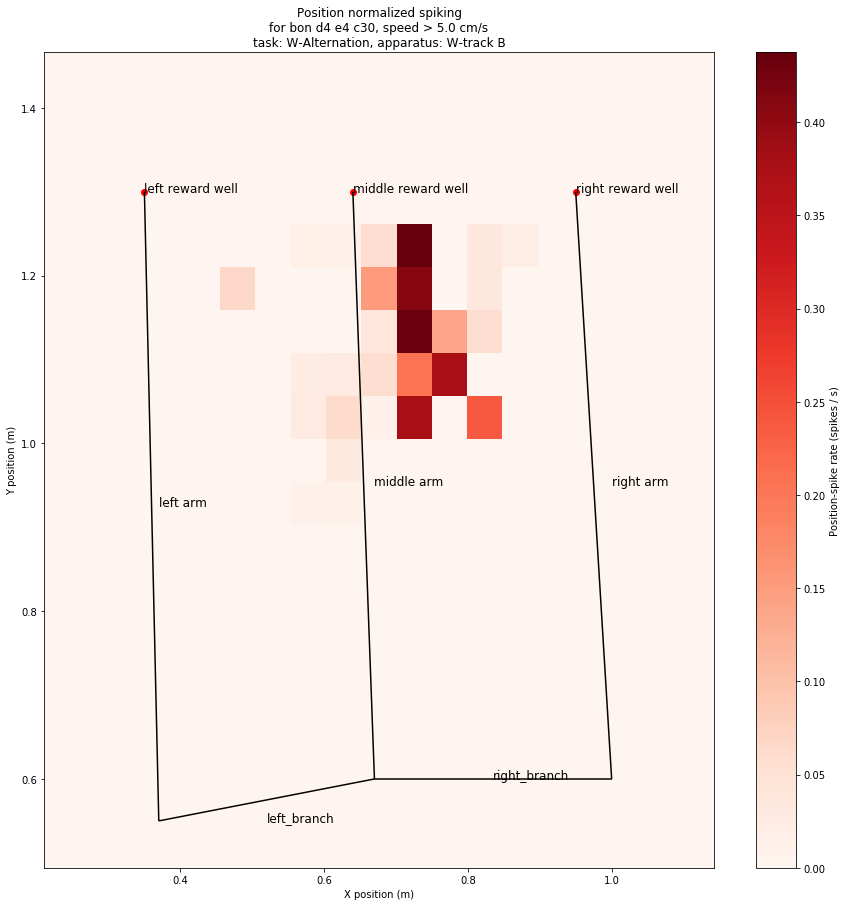

In [18]:
padding = 0.1
nbins = 20
minx = np.min(position.samples['x'])
maxx = np.max(position.samples['x'])
miny = np.min(position.samples['y'])
maxy = np.max(position.samples['y'])
binsx = np.linspace(minx-padding, maxx+padding, nbins)
binsy = np.linspace(miny-padding, maxy+padding, nbins)

# Compute histogram of position during entire epoch
fig1 = plt.figure(figsize=(15,15))
ax1 = plt.subplot(111)
plt.title('Animal position')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
n_pos, xbins_pos, ybins_pos, img_pos = plt.hist2d(position.samples['x'], position.samples['y'], bins=[binsx, binsy], cmap='Reds')
cbar = plt.colorbar()
cbar.set_label('Time spent (s)')
flh.plot_fl_appar_geom(appar, ax1, label_nodes=True) # Plot apparatus geometry


# Compute histogram of position during spiking
fig2 = plt.figure(figsize=(15,15))
ax2 = plt.subplot(111)
plt.title('Spike-position')
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
n_spikes, xbins_spikes, ybins_spikes, img_pos = plt.hist2d(spiking_run_mark_pos.marks['x'], spiking_run_mark_pos.marks['y'], bins=[binsx, binsy], cmap='Reds')
cbar = plt.colorbar()
cbar.set_label('Number of spikes')
flh.plot_fl_appar_geom(appar, ax2, label_nodes=True) # Plot apparatus geometry


# Compute position normalized spiking
n_pos = np.add(n_pos, 0.0001)
norm_spikes = np.divide(n_spikes, n_pos)

# Plot position normalized spiking
fig3 = plt.figure(figsize=fig2.get_size_inches())
ax3 = plt.subplot(111)
plt.title('Position normalized spiking\nfor {} d{} e{} c{}, speed > {:0.1f} cm/s\ntask: {}, apparatus: {}'.format(
    d['anim'], d['day'], d['epoch'], d['cluster_id'], c['speed_threshold'] * 100, task.name, appar.name))
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
plt.imshow(norm_spikes.T, origin='lower', aspect='auto', cmap='Reds', extent=(minx, maxx, miny, maxy))
cbar = plt.colorbar()
cbar.set_label('Position-spike rate (spikes / s)')
flh.plot_fl_appar_geom(appar, ax3, label_nodes=True) # Plot apparatus geometry



# Close the file io
io.close()

In [4]:
sleep_epochs = []
for i, task in enumerate(nwbf.epochs['task'][:]):
    if task.name == 'Sleep':
        sleep_epochs.append(i+1) # epochs are 1-indexed
        
all_sleep_pos = {}
for sleep_epoch in sleep_epochs:
    position_module_name = 'Position d{:d} e{:d}'.format(d['day'], sleep_epoch) # HACKY--we should query on epoch directly
    position_h5py = nwbf.modules['Behavior']['Position'][position_module_name]
    position_data = pd.DataFrame(data=position_h5py.data[()], columns=['x', 'y'])
    all_sleep_pos[sleep_epoch] = ContinuousData(samples=position_data, sample_times=position_h5py.timestamps[()])

### Plot animal positions during sleep epochs, overlaid on the sleep box
Use Network X to extract and plot the sleep box geometry.

/Users/ericmiller/anaconda/envs/pynwb/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


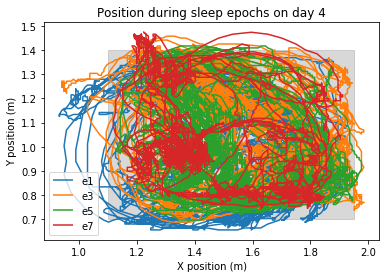

In [5]:
# Plot position of the animal during each sleep epoch
plt.figure()
plt.title('Position during sleep epochs on day {}'.format(d['day']))
plt.xlabel('X position (m)')
plt.ylabel('Y position (m)')
ax = plt.subplot(111)
for epoch, sleep_pos in all_sleep_pos.items():
    plt.plot(sleep_pos.samples['x'], sleep_pos.samples['y'], marker='', label='e{}'.format(epoch))

# Get the Sleep Box apparatus (Same apparatus for all sleep epochs, so just use the first)
first_sleep_epoch = sleep_epochs[0] - 1  # epochs table is 0-indexed
appar = nwbf.epochs['apparatus'][first_sleep_epoch]

# Convert the Frank Lab apparatus to a Network X graph and plot it
H = nx.Graph(name='sleep box')
for n in appar.nodes.values():
    flh.add_fl_node_to_nx_graph(n, H)
flh.plot_nx_appar_geom(H, ax)
ax.legend()
pass